MDSI, UTS , Autumn / 2021 , Big Data Engineering(94693)

AT3 - Streaming with Kafka and Spark Streaming , 13 June 2021
 
Group Project by
* Irfan
* Ming 
* Jedo
* Hnin Pwint Tin / 13738339  

File name - AT3_Part3e_Visualisation.py 

This script intends to perform visualisation of Real-Time Car Park Occupancy Rate on Stream Data

Prior to running this script, AT3_Producer.ipnyb has to be run.

In [16]:
from IPython.display import display, clear_output
import time

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import pyspark.sql.functions as sf

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Create SparkSession

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

#### Define Schema of Stream - Carpark facility 

In [3]:
## Create the schema of the value field for Car Park Facility
schema_car_park_facility_stream = StructType([
    StructField("facility_id", StringType(),  True),
    StructField("tsn", StringType(),  True),
    StructField("park_id", StringType(),  True),
    StructField("facility_name", StringType(),  True),
    StructField("time", StringType(),  True),
    StructField("spots", StringType(),  True),
    StructField("message_date", StringType(),  True),
    StructField("tfnsw_facility_id", StringType(), True),
    StructField("facility_occupancy_loop", StringType(), True),
    StructField("facility_occupancy_total", StringType(), True),
    StructField("facility_occupancy_monthlies", StringType(),  True),
    StructField("facility_occupancy_open_gate", StringType(), True),
    StructField("facility_occupancy_transients", StringType(), True),
])

In [4]:
### Subscribe the topic "nsw_car_park_facility" from the Kafka broker and 
### Read the earlierst data into the Spark dataframe called car_park_facility_stream_df
car_park_facility_stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "nsw_car_park_facility") \
  .load()

### Convert the columns key and value from stream_df to string and 
### Save the results into the dataframe again
car_park_facility_stream_df = car_park_facility_stream_df \
    .withColumn("key", car_park_facility_stream_df["key"].cast(StringType())) \
    .withColumn("value", car_park_facility_stream_df["value"].cast(StringType()))

### Convert the column value of string_stream_df to JSON and
### Save the results to the dataframe again 
car_park_facility_stream_df = car_park_facility_stream_df \
    .withColumn("value", F.from_json("value", schema_car_park_facility_stream))

### Flatten the columns from value and rename the columns key, topic, timestamp to respectively event_key, event_topic, event_timestamp
car_park_facility_stream_df = car_park_facility_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.facility_id", \
        "value.tsn", \
        "value.park_id", \
        "value.facility_name", \
        "value.time", \
        "value.spots", \
        "value.message_date", \
        "value.tfnsw_facility_id", \
        "value.facility_occupancy_loop", \
        "value.facility_occupancy_total", \
        "value.facility_occupancy_monthlies", \
        "value.facility_occupancy_open_gate", \
        "value.facility_occupancy_transients"
    )

### Print the schema of car_park_facility_stream_df
car_park_facility_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- facility_id: string (nullable = true)
 |-- tsn: string (nullable = true)
 |-- park_id: string (nullable = true)
 |-- facility_name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- spots: string (nullable = true)
 |-- message_date: string (nullable = true)
 |-- tfnsw_facility_id: string (nullable = true)
 |-- facility_occupancy_loop: string (nullable = true)
 |-- facility_occupancy_total: string (nullable = true)
 |-- facility_occupancy_monthlies: string (nullable = true)
 |-- facility_occupancy_open_gate: string (nullable = true)
 |-- facility_occupancy_transients: string (nullable = true)



### Export the Stream data to Memory to view
from car_park_facility_stream_df as a queryable view called nsw_car_park_facility_view

In [5]:
car_park_facility_stream = car_park_facility_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("nsw_car_park_facility_view") \
    .start()

### Real-time Visualisation of Occupancy in the Top Five Largest Car Park Facilities

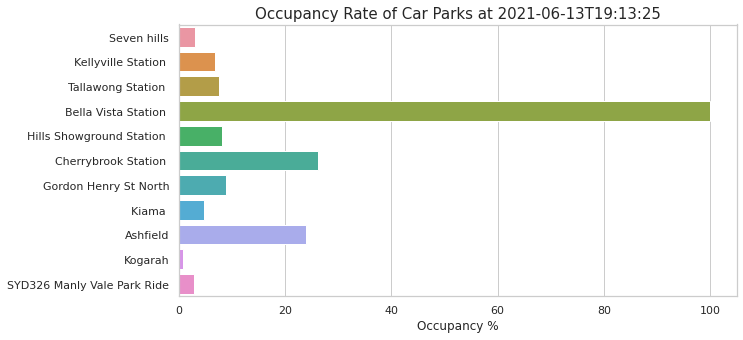

In [17]:
try:
    while(True):
        clear_output(wait=True)
        nsw_car_park_facility_df = spark.sql(""" SELECT 
                                                message_date, event_timestamp, 
                                                facility_id,
                                                regexp_replace(facility_name, 'Car Park', '') as facility_name,
                                                cast (spots as INT),
                                                cast (facility_occupancy_total as INT)
                                            FROM nsw_car_park_facility_view   
                                            """)
        nsw_car_park_facility_pd_df = nsw_car_park_facility_df.toPandas()

        largest_list = ['488', '2', '1', '3', '4', '5', '6', '7', '486', '487', '489']
        top_largest_facility_df = pd.DataFrame()
        for i in largest_list:

            facility = nsw_car_park_facility_pd_df[(nsw_car_park_facility_pd_df['facility_id'] == i)]
            facility = facility.loc[facility['event_timestamp'] == facility['event_timestamp'].max()].drop_duplicates()

            facility['occupancy_percent'] = ((facility['facility_occupancy_total'] / facility['spots'] ) * 100 ).round(decimals=2)
            top_largest_facility_df = top_largest_facility_df.append(facility)


        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(10, 5))
        reading_time = top_largest_facility_df['message_date'].iloc[0]

        bp = sns.barplot(x="occupancy_percent", y="facility_name", data=top_largest_facility_df)
        bp.set_title("Occupancy Rate of Car Parks at " + reading_time ,fontsize=15)
        bp.set(xlabel="Occupancy %", ylabel="")

        plt.show()     
        time.sleep(300)

except KeyboardInterrupt:
    pass

In [ ]:
car_park_facility_stream.stop()

In [49]:
spark.stop()